In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [41]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

np.random.seed(42)
from sklearn.metrics import confusion_matrix

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder

In [42]:
skin_df = pd.read_csv('/content/drive/MyDrive/Skin_Cancer_Dataset/HAM10000_metadata.csv')

In [43]:
SIZE=64

**label encoding to numeric values from text**

In [44]:
le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [45]:
skin_df['label'] = le.transform(skin_df["dx"]) 
print(skin_df.sample(10))

        lesion_id      image_id   dx  ...     sex     localization label
1617  HAM_0007180  ISIC_0033272  mel  ...    male             face     4
8128  HAM_0007195  ISIC_0031923   nv  ...  female  lower extremity     5
2168  HAM_0001835  ISIC_0026652  mel  ...    male             back     4
1090  HAM_0000465  ISIC_0030583  bkl  ...  female            trunk     2
7754  HAM_0001720  ISIC_0034010   nv  ...    male          abdomen     5
8071  HAM_0006333  ISIC_0024424   nv  ...    male            trunk     5
7423  HAM_0004548  ISIC_0032832   nv  ...  female  upper extremity     5
8984  HAM_0006526  ISIC_0026671   nv  ...    male  lower extremity     5
2310  HAM_0003102  ISIC_0032389  mel  ...    male             face     4
7256  HAM_0004260  ISIC_0025525   nv  ...    male             back     5

[10 rows x 8 columns]


**Data distribution visualization**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


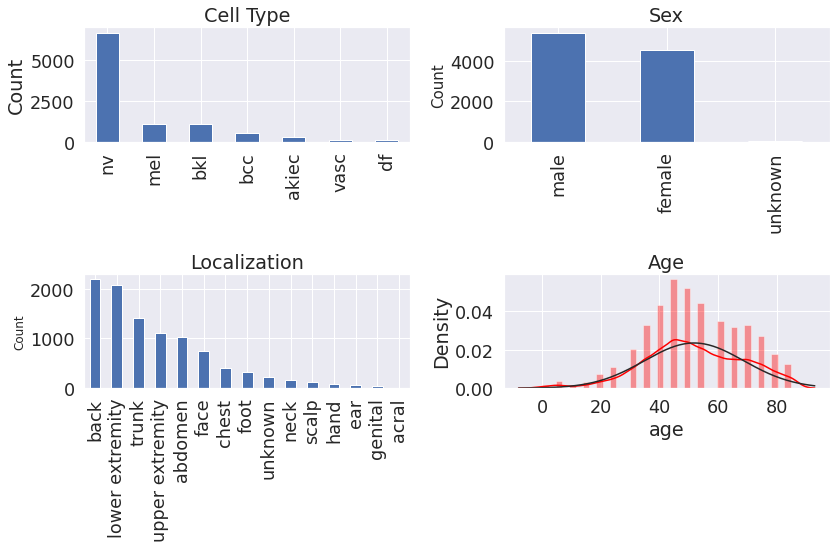

In [46]:
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')

ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Age')

plt.tight_layout()
plt.show()

**Distribution of data into various classes**

In [47]:
from sklearn.utils import resample
print(skin_df['label'].value_counts())

5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: label, dtype: int64


**Balancing data**

In [49]:
df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]
df_2 = skin_df[skin_df['label'] == 2]
df_3 = skin_df[skin_df['label'] == 3]
df_4 = skin_df[skin_df['label'] == 4]
df_5 = skin_df[skin_df['label'] == 5]
df_6 = skin_df[skin_df['label'] == 6]

n_samples=500

df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42) 
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42) 
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)

**Combined back to a single dataframe**

In [50]:
skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                              df_2_balanced, df_3_balanced, 
                              df_4_balanced, df_5_balanced, df_6_balanced])

**Check the distribution. All classes should be balanced now.**

In [51]:
print(skin_df_balanced['label'].value_counts())

5    500
3    500
1    500
6    500
4    500
2    500
0    500
Name: label, dtype: int64


**Now time to read images based on image ID from the CSV file.
This is the safest way to read images as it ensures the right image is read for the right ID**

In [52]:
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('/content/drive/MyDrive/Skin_Cancer_Dataset/', '*', '*.jpg'))}


**Define the path and add as a new column**

In [53]:
skin_df_balanced['path'] = skin_df['image_id'].map(image_path.get)

In [54]:
print(skin_df_balanced.sample(10))

        lesion_id  ...                                               path
2379  HAM_0001852  ...  /content/drive/MyDrive/Skin_Cancer_Dataset/HAM...
9919  HAM_0006442  ...  /content/drive/MyDrive/Skin_Cancer_Dataset/HAM...
2347  HAM_0007614  ...  /content/drive/MyDrive/Skin_Cancer_Dataset/HAM...
2387  HAM_0004820  ...  /content/drive/MyDrive/Skin_Cancer_Dataset/HAM...
1153  HAM_0007418  ...  /content/drive/MyDrive/Skin_Cancer_Dataset/HAM...
704   HAM_0004630  ...  /content/drive/MyDrive/Skin_Cancer_Dataset/HAM...
90    HAM_0002921  ...  /content/drive/MyDrive/Skin_Cancer_Dataset/HAM...
955   HAM_0000332  ...  /content/drive/MyDrive/Skin_Cancer_Dataset/HAM...
9730  HAM_0006222  ...  /content/drive/MyDrive/Skin_Cancer_Dataset/HAM...
8843  HAM_0006685  ...  /content/drive/MyDrive/Skin_Cancer_Dataset/HAM...

[10 rows x 9 columns]


**Use the path to read images**

In [55]:
skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))

**Plotting**

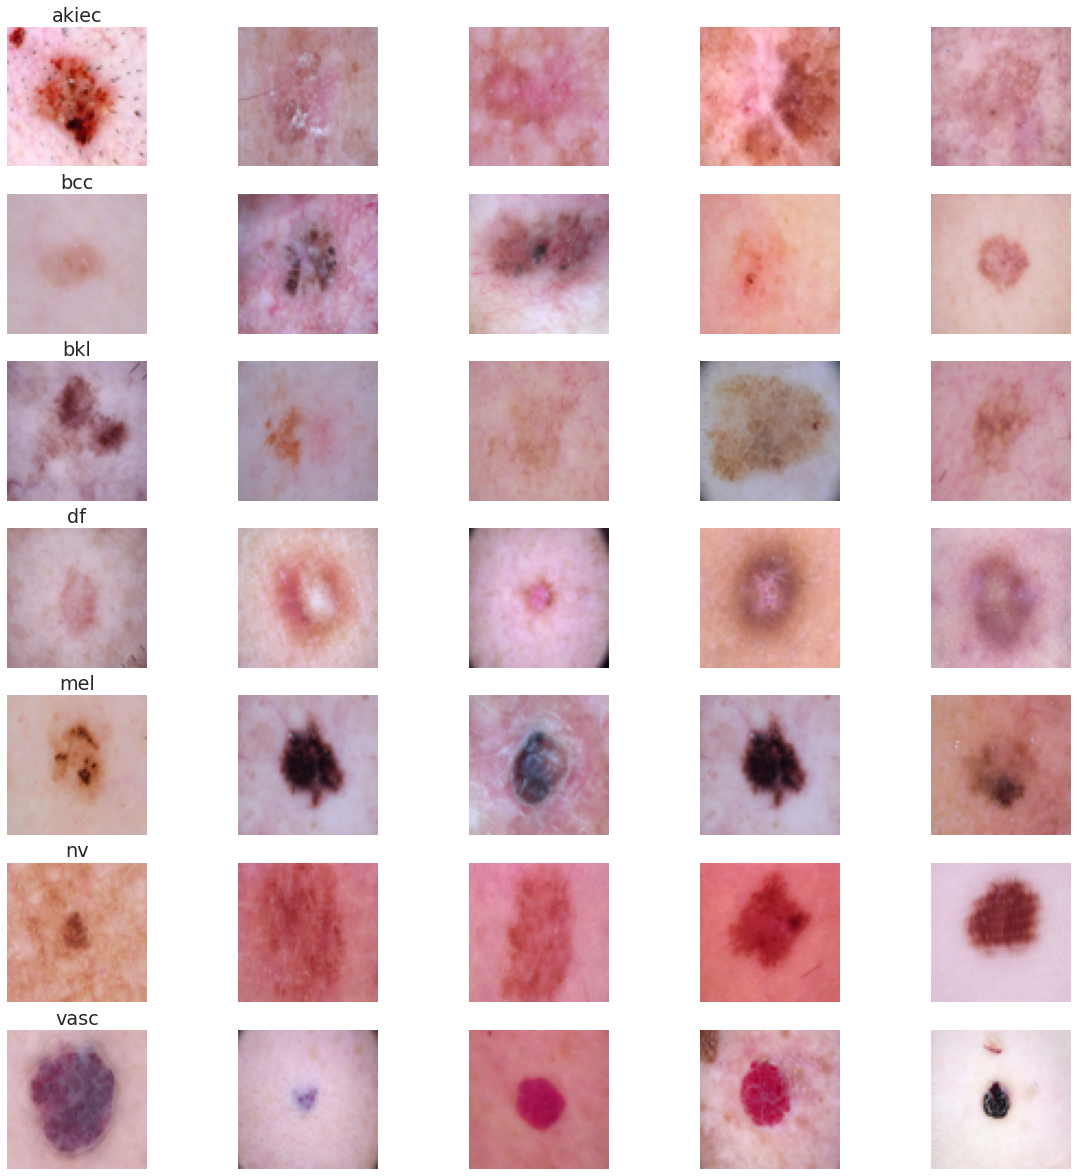

In [56]:
n_samples = 5  # number of samples for plotting

fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df_balanced.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

**Convert dataframe column of images into numpy array**

In [57]:
X = np.asarray(skin_df_balanced['image'].tolist())
X = X/255.  # Scale values to 0-1. We can also used standardscaler or other scaling methods.
Y=skin_df_balanced['label']  #Assign label values to Y
Y_cat = to_categorical(Y, num_classes=7) #Convert to categorical as this is a multiclass classification problem

**Split to training and testing**

In [59]:
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)

**Define the model. I've used autokeras to find out the best model for this problem. We can also load pretrained networks such as mobilenet or VGG16**

In [60]:
num_classes = 7

model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(SIZE, SIZE, 3)))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(7, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 62, 62, 256)       7168      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 256)       0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 31, 31, 256)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 29, 29, 128)       295040    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 12, 12, 64)       

#**Train**
**We can also use generator to use augmentation during training.**


In [72]:
batch_size = 16 
epochs = 150

In [73]:
history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(x_test, y_test),
    verbose=2)

Epoch 1/150
165/165 - 2s - loss: 0.3315 - acc: 0.8796 - val_loss: 0.8880 - val_acc: 0.7611
Epoch 2/150
165/165 - 2s - loss: 0.2986 - acc: 0.8937 - val_loss: 0.9040 - val_acc: 0.7486
Epoch 3/150
165/165 - 2s - loss: 0.3059 - acc: 0.8899 - val_loss: 0.8705 - val_acc: 0.7543
Epoch 4/150
165/165 - 2s - loss: 0.2678 - acc: 0.9010 - val_loss: 0.9186 - val_acc: 0.7657
Epoch 5/150
165/165 - 2s - loss: 0.2678 - acc: 0.8968 - val_loss: 0.9284 - val_acc: 0.7703
Epoch 6/150
165/165 - 2s - loss: 0.2612 - acc: 0.9040 - val_loss: 0.9152 - val_acc: 0.7691
Epoch 7/150
165/165 - 2s - loss: 0.3004 - acc: 0.8869 - val_loss: 0.9453 - val_acc: 0.7463
Epoch 8/150
165/165 - 2s - loss: 0.2814 - acc: 0.9002 - val_loss: 0.9203 - val_acc: 0.7600
Epoch 9/150
165/165 - 2s - loss: 0.2758 - acc: 0.9036 - val_loss: 0.8878 - val_acc: 0.7703
Epoch 10/150
165/165 - 2s - loss: 0.2799 - acc: 0.9017 - val_loss: 0.8678 - val_acc: 0.7749
Epoch 11/150
165/165 - 2s - loss: 0.2686 - acc: 0.9029 - val_loss: 0.9725 - val_acc: 0.75

In [74]:
score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])

28/28 [==============================] - 0s 8ms/step - loss: 1.0835 - acc: 0.7760
Test accuracy: 0.7760000228881836


In [75]:
model.save_weights("/content/drive/MyDrive/Skin_Cancer_Model.h5")

**plot the training and validation accuracy and loss at each epoch**

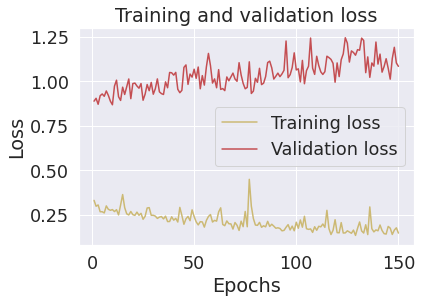

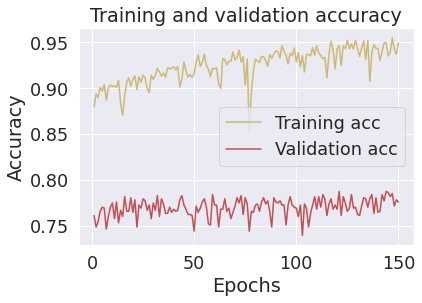

In [76]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#**Prediction on test data**

In [77]:
y_pred = model.predict(x_test)

**Convert predictions classes to one hot vectors**

In [78]:
y_pred_classes = np.argmax(y_pred, axis = 1)

**Convert test data to one hot vectors**

In [79]:
y_true = np.argmax(y_test, axis = 1) 

**Print confusion matrix**

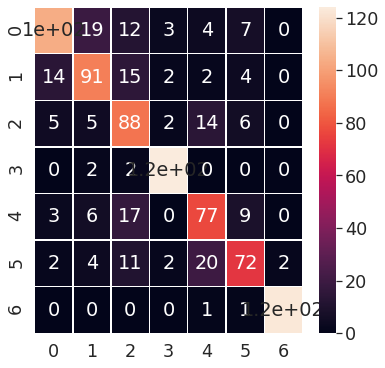

In [80]:
cm = confusion_matrix(y_true, y_pred_classes)

fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

**Plot fractional incorrect misclassifications**

Text(0, 0.5, 'Fraction of incorrect predictions')

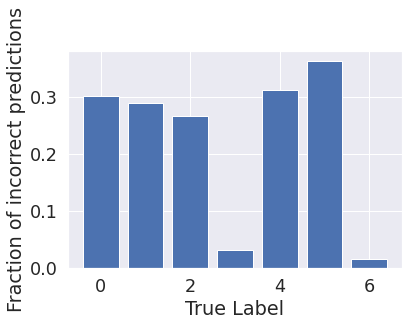

In [81]:
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(7), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')